In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import tonic
from IPython.display import HTML

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

d:\Program Files\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:

downsample_size = (128,128) #i think that downsampling removes too much information 
slice_meta_path = "./tmp/DVS_sliced/"

dtype=torch.float
torch.manual_seed(734)
print("Convolutional SNN Trained on DVS Gesture")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=32 #you wanna set this so that the gpu uses all its dedicated memory but not any shared i.e. not swapping to main ram
data_path='./tmp/data/DVS/'
num_classes = 11  # DVS has 10 output classes, one for out of class

frame_time = 10

num_steps = 60  # assuming 16 steps as we use 16ms filter window, chip runs at 1ms; can also get decent accuracy using 16 timesteps on spiking MNIST
# 60 frames 1ms or 5ms apart

transform1 = tonic.transforms.Compose([tonic.transforms.ToFrame(sensor_size=(128,128,2),n_time_bins=num_steps), lambda x: x.astype(np.float32)]) #for some reason using time_window results in sometimes getting 95 frames

#downsample to stay consistent with paper + helps save memory

train_dvs = tonic.datasets.DVSGesture(data_path,train=True)
test_dvs = tonic.datasets.DVSGesture(data_path,train=False)
#TODO consider using  DiskCachedDataset for performance
slicer = tonic.slicers.SliceByTime(60*frame_time*1000,59*frame_time*1000,False) #for some reason, it gives me one less frame than i need, hence 97=>96+1 (000)
#allow an overlap such that we start a new slice at every 16ms - each frame in a 16ms window will be presented to feature i during training, but only once. if you want multiple exposure just use multiple epochs
 
#TODO careful , you will need to regenerate after changing parameters, however without it takes about 30 seconds to generate the slices
#slice our dataset - we do not need the entire dataset at once
train_sliced_dvs = tonic.SlicedDataset(train_dvs,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"train/")
test_sliced_dvs = tonic.SlicedDataset(test_dvs,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"test/")

train_loader = DataLoader(train_sliced_dvs, batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(test_sliced_dvs, batch_size=batch_size, shuffle=True,drop_last=False)



Convolutional SNN Trained on DVS Gesture
Using device: cuda
Metadata read from ./tmp/DVS_sliced/train/slice_metadata.h5.
Metadata read from ./tmp/DVS_sliced/test/slice_metadata.h5.


training samples:  631108
testing samples:  163636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Left arm ccw
torch.Size([32, 60, 2, 128, 128])


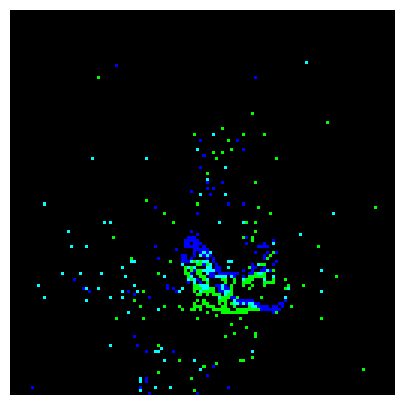

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [3]:
print("training samples: ",len(train_sliced_dvs))
print("testing samples: ",len(test_sliced_dvs))
#if you want to create more samples you can change the overlap (but you might cause overfitting)

a = next(iter(test_loader))
print(test_dvs.classes[a[1][0]])
print(a[0].shape)
animation = tonic.utils.plot_animation(frames=a[0][0])
display(HTML(animation.to_jshtml()))

In [4]:


################ DVS Gesture Model #############################

# (without temporal layer - this is up for interpretation)

# layer parameters

beta = 0.95
lr=1e-4
#weight_decay=1e-6

spike_grad1 = surrogate.atan()

class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        #from table 1 in DVS paper
        #TODO im multiplying features by two as paper states 6 input features, but we have seperate channels for increase/decrease events
        self.layers = nn.ModuleList([
            #64x64
            nn.MaxPool2d(4),
            nn.Conv2d(2,64,3),
            nn.Conv2d(64,128,3),
            nn.AvgPool2d(2),
            nn.Conv2d(128,128,3),
            nn.AvgPool2d(2),
            nn.Linear(4608,256),
            nn.Linear(256,11)
        ])

        # initialize neurons
        self.neurons = nn.ModuleList(
            [snn.Leaky(beta=beta,spike_grad=spike_grad1)] * 8
        )

        self.to(device) #yes, this is needed twice
        
        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

  
    def forward(self,x): #x is input data
        #events should be treated as spikes i.e. already encoded

        # Initialize hidden states
        mem = []
        for i in range(8):
            mem.append(self.neurons[i].init_leaky())
        
        # record spike outputs
        spk_rec = []

        for step in range(num_steps):
            #form inputs
            spk_i = x[:,step]

            for i in range(8):
                if(i==6): #need to flatten from AvgPool to Linear
                    spk_i = torch.flatten(spk_i,start_dim=1)
                cur_i = self.layers[i](spk_i)
                spk_i, mem[i] = self.neurons[i](cur_i,mem[i])

            spk_rec.append(spk_i)
            


        return torch.stack(spk_rec, dim=0) #TODO do i really need to return membrane potentials
    
###################################################################################



In [5]:
'''a = next(iter(test_loader))
print(a[0].shape)
print(a[0].dtype)

net = Net().to(device)
net.train()
r = net.forward(a[0].to(device))
print("r: ",r.shape)
print(torch.max(r))'''
#comment this out to reduce GPU memory usage

'a = next(iter(test_loader))\nprint(a[0].shape)\nprint(a[0].dtype)\n\nnet = Net().to(device)\nnet.train()\nr = net.forward(a[0].to(device))\nprint("r: ",r.shape)\nprint(torch.max(r))'

In [6]:
count = 0

########### STATS ##############

def print_stats(data, targets):
    output = net(data)
    acc  = net.accuracy_metric(output, targets)
    #dev = np.std((targets == idx).detach().cpu().numpy()) #TODO deviation for latency encoding
    print(f"    Accuracy: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {img_counter}, Minibatch stats:")
    print(f"    Train Set Loss: {loss_hist[batch_counter]:.2f}")
    print(f"    Test Set Loss: {test_loss_hist[img_counter]:.2f}")
    print_stats(test_data, test_targets)
    print("Train batch: ")
    print_stats(data, targets)
    print("\n")


############################## MAIN TRAINING LOOP ###########################################


# Load the network onto CUDA
net = Net().to(device)
optimiser = torch.optim.Adam(net.parameters(),lr=lr)

num_epochs = 1
loss_hist = []
test_loss_hist = []

iterations = 0

#training loop
for epoch in range(num_epochs):

    #mini-batch loop
    for data, targets in tqdm(iter(train_loader)):

        data = data.float().to(device)
        targets = targets.to(device)
        
        # forward pass
        net.train() #inform pytorch
        spk_rec = net(data)

        #calculate loss as cross entropy of membrane potential at each step
        loss_val = net.loss(spk_rec,targets)

        
        optimiser.zero_grad() #(reset for batch)
        loss_val.backward() #calculate backpropogation error gradient
        optimiser.step() #then update parameters

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        iterations +=1

        # Test set
        if iterations % 50 == 0:
                
            with torch.no_grad(): #tell pytorch to disable gradient calculation (save compute)
                net.eval()

                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Test set forward pass
                test_spk = net(test_data)

                # Test set loss
                test_loss = net.loss(test_spk,test_targets)
                test_loss_hist.append(test_loss.item())
                # Print train/test loss/accuracy
                train_printer()



###############################################################################################


  0%|          | 0/19723 [00:00<?, ?it/s]

Epoch 0, Iteration 0, Minibatch stats:
    Train Set Loss: 2.48
    Test Set Loss: 2.50
    Accuracy: 12.50%
Train batch: 


  0%|          | 1/19723 [00:04<23:16:50,  4.25s/it]

    Accuracy: 6.25%




  1%|          | 164/19723 [04:04<8:05:08,  1.49s/it]


KeyboardInterrupt: 

In [ ]:
#torch.save(net.state_dict(),"./models/DVS2_lr_1e-4.pt")
'''
net = Net().to(device)
net.load_state_dict(torch.load("./models/DVS2_lr_1e-4.pt"))
#loss graph wont be after reload TODO
'''

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

total = 0
correct = 0

# drop_last switched to False to keep all samples

with torch.no_grad():
  net.eval()
  accs = []
  for i, (data, targets) in enumerate(test_loader):
    if i>100: break
    data = data.to(device)
    targets = targets.to(device)

    output = net.forward(data)
    accs.append(net.accuracy_metric(output,targets))
  
  print("mean accuracy: ",np.mean(accs))